Loading fpe_training_data.npy...
Total Steps: 51
Split: Washout=5, Train=25, Test=21

--- Training ---
R2 Score: 0.99994
--- Testing ---
Prediction Shape: (20, 200)


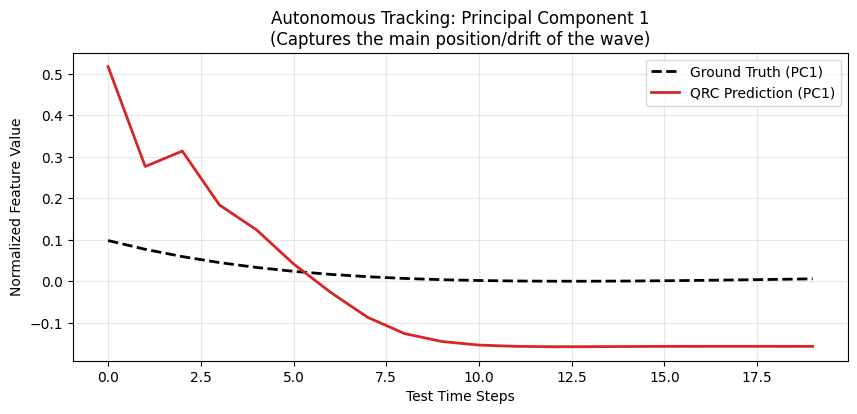

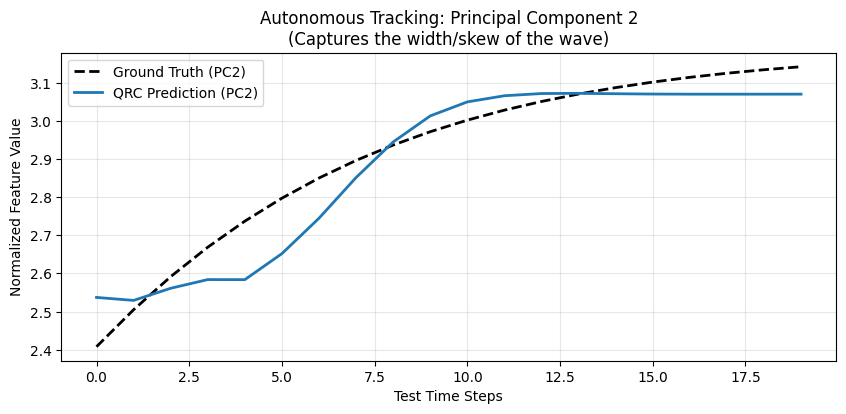

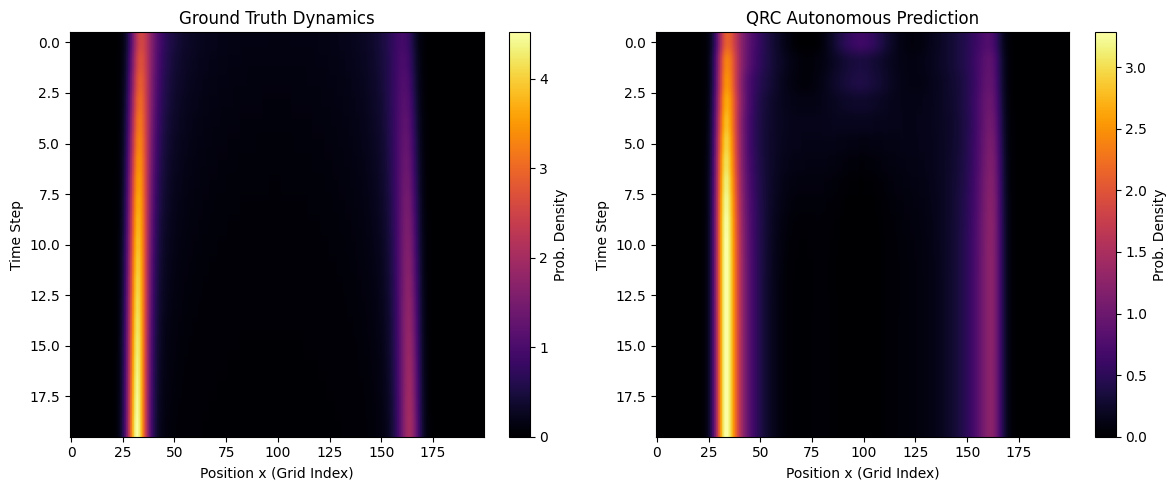

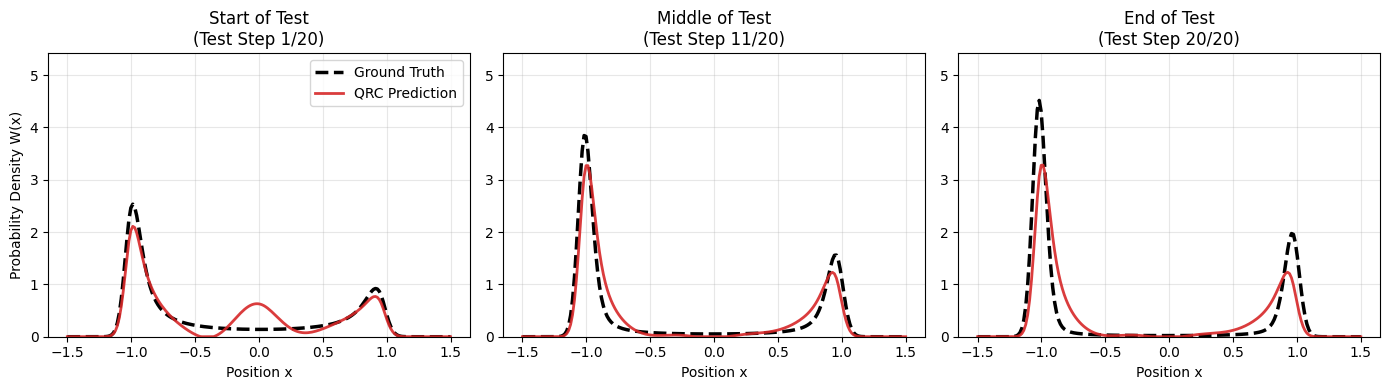


 ACCURACY REPORT (Train Len: 25)
MSE (Raw Error):       5.862980e-02
NMSE (Normalized):     0.1234  <-- Aim for < 0.1
Avg Fidelity:          0.9393  <-- Aim for > 0.95
------------------------------


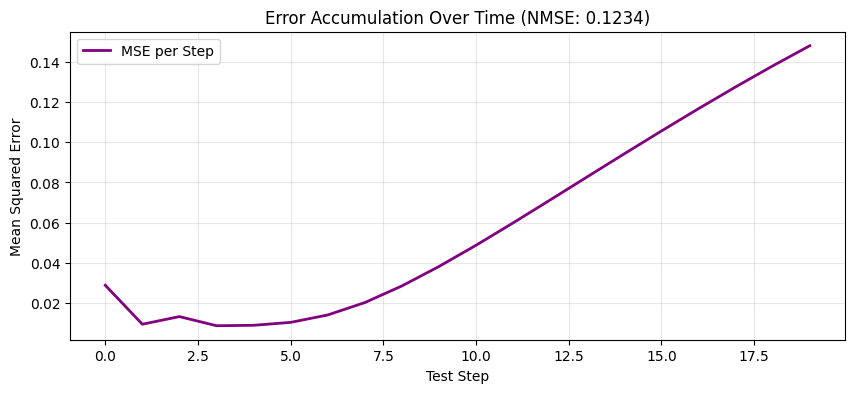

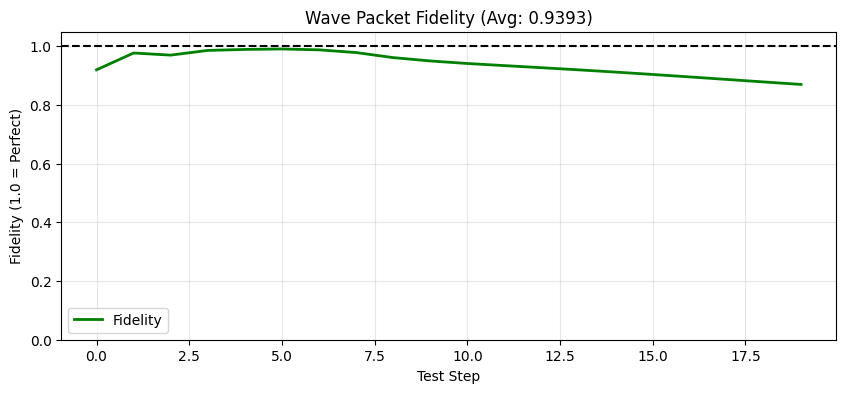

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import expm
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
import qiskit.quantum_info

# --- 1. CONFIGURATION ---
filename = 'fpe_training_data.npy'
washout_len = 5
train_len = 25   
n_inputs = 4     
nqbits = 10       
alpha_reg = 0.001 

# --- 2. DATA PREPARATION ---
print(f"Loading {filename}...")
data_full = np.load(filename)
n_time_steps = data_full.shape[0]
test_len = n_time_steps - washout_len - train_len

print(f"Total Steps: {n_time_steps}")
print(f"Split: Washout={washout_len}, Train={train_len}, Test={test_len}")

# PCA Compression
pca = PCA(n_components=n_inputs)
pca.fit(data_full[:washout_len+train_len])
data_pca = pca.transform(data_full)

# Scaling to [0, pi]
scaler = MinMaxScaler(feature_range=(0, np.pi))
data_scaled = scaler.fit_transform(data_pca)

# Training Sets
X_train_pca = data_scaled[washout_len : washout_len + train_len]     
Y_train_full = data_full[washout_len + 1 : washout_len + train_len + 1] 

# Testing Sets (Ground Truth)
Y_test_full_gt = data_full[washout_len + train_len + 1 :] 

# --- 3. QUANTUM RESERVOIR SETUP ---

# Dense Unitary 
def get_ising_unitary_dense(nqbits, J, t):
    np.random.seed(42) 
    Js = np.random.uniform(-J/2, J/2, size=nqbits-1)
    h = J * 0.1
    pauli_list = []
    for i in range(nqbits - 1):
        label = ["I"] * nqbits; label[i] = "Z"; label[i+1] = "Z"
        pauli_list.append(("".join(label), Js[i]))
    for i in range(nqbits):
        label = ["I"] * nqbits; label[i] = "X"
        pauli_list.append(("".join(label), h))
    H_matrix = SparsePauliOp.from_list(pauli_list).to_matrix()
    return expm(-1j * H_matrix * t)

U = get_ising_unitary_dense(nqbits, J=0.5, t=5)

# Measurement Operators
observables = []
for i in range(nqbits):
    for p in ["Z", "X"]:
        label = ["I"] * nqbits
        label[i] = p
        observables.append(SparsePauliOp("".join(label)).to_matrix())

# Helper Functions
def encode_and_combine(features, rho_memory, n_inputs):
    qc = QuantumCircuit(n_inputs)
    for i in range(n_inputs):
        qc.ry(features[i], i)
    psi = np.array(qiskit.quantum_info.Statevector(qc))
    rho_in = np.outer(psi, psi.conj())
    
    # If inputs fill the whole reservoir, we don't need to partial trace
    if n_inputs == nqbits:
        return rho_in
        
    # Standard reservoir logic (if nqbits > n_inputs)
    indices_to_trace = list(range(n_inputs))
    rho_mem_reduced = qiskit.quantum_info.partial_trace(rho_memory, indices_to_trace).data
    return np.kron(rho_in, rho_mem_reduced)

def measure(rho, obs_list):
    return np.array([np.trace(rho @ ob).real for ob in obs_list])

# --- 4. TRAINING LOOP ---
print("\n--- Training ---")
rho = np.zeros((2**nqbits, 2**nqbits)); rho[0,0] = 1.0
X_res = []

# Washout
for t in range(washout_len):
    rho = U.conj().T @ rho @ U
    rho = encode_and_combine(data_scaled[t+1], rho, n_inputs)

# Train
for t in range(train_len):
    rho = U.conj().T @ rho @ U
    X_res.append(measure(rho, observables))
    if t < train_len - 1:
        rho = encode_and_combine(X_train_pca[t+1], rho, n_inputs)

X_res = np.array(X_res)
ridge = Ridge(alpha=alpha_reg) 
ridge.fit(X_res, Y_train_full)
print(f"R2 Score: {ridge.score(X_res, Y_train_full):.5f}")

# --- 5. AUTONOMOUS TESTING ---
print("--- Testing ---")

predictions = []
curr_rho = rho 
Y_test_full_gt = data_full[washout_len + train_len + 1 :]
steps_to_predict = len(Y_test_full_gt)

for t in range(steps_to_predict):
    # 1. Evolve
    curr_rho = U.conj().T @ curr_rho @ U
    
    # 2. Measure & Predict
    meas = measure(curr_rho, observables)
    pred_vec = ridge.predict(meas.reshape(1, -1)).flatten()
    pred_vec[pred_vec < 0] = 0 # Physics constraint
    predictions.append(pred_vec)
    
    # 3. Feedback (Autonomous)
    pred_pca = scaler.transform(pca.transform(pred_vec.reshape(1,-1))).flatten()
    curr_rho = encode_and_combine(pred_pca, curr_rho, n_inputs)

predictions = np.array(predictions)

print(f"Prediction Shape: {predictions.shape}")

# --- 7. DETAILED VISUALIZATION ---

# 1. Project predictions and ground truth back into the PCA Latent Space
pred_pca_history = scaler.transform(pca.transform(predictions))
gt_pca_history = scaler.transform(pca.transform(Y_test_full_gt))

# Create a time axis for the plots
time_steps = np.arange(len(predictions))

# --- Plot A: Principal Component 1 (Drift/Position) ---
plt.figure(figsize=(10, 4))
plt.plot(time_steps, gt_pca_history[:, 0], label="Ground Truth (PC1)", color='black', linestyle='--', linewidth=2)
plt.plot(time_steps, pred_pca_history[:, 0], label="QRC Prediction (PC1)", color='#d62728', linewidth=2)
plt.title(f"Autonomous Tracking: Principal Component 1\n(Captures the main position/drift of the wave)")
plt.xlabel("Test Time Steps")
plt.ylabel("Normalized Feature Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot B: Principal Component 2 (Diffusion/Shape) ---
plt.figure(figsize=(10, 4))
plt.plot(time_steps, gt_pca_history[:, 1], label="Ground Truth (PC2)", color='black', linestyle='--', linewidth=2)
plt.plot(time_steps, pred_pca_history[:, 1], label="QRC Prediction (PC2)", color='#1f77b4', linewidth=2)
plt.title(f"Autonomous Tracking: Principal Component 2\n(Captures the width/skew of the wave)")
plt.xlabel("Test Time Steps")
plt.ylabel("Normalized Feature Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot C: Full System Evolution Heatmap ---
plt.figure(figsize=(12, 5))

# Ground Truth
plt.subplot(1, 2, 1)
plt.imshow(Y_test_full_gt, aspect='auto', cmap='inferno', origin='upper')
plt.title(f"Ground Truth Dynamics")
plt.xlabel("Position x (Grid Index)")
plt.ylabel("Time Step")
plt.colorbar(label="Prob. Density")

# QRC Prediction
plt.subplot(1, 2, 2)
plt.imshow(predictions, aspect='auto', cmap='inferno', origin='upper')
plt.title(f"QRC Autonomous Prediction")
plt.xlabel("Position x (Grid Index)")
plt.ylabel("Time Step")
plt.colorbar(label="Prob. Density")

plt.tight_layout()
plt.show()

# --- Plot D: W(x, t) Cross-Sections (Slices) ---

# Reconstruct x-axis
x_vals = np.linspace(-1.5, 1.5, 200)

# Select time points to compare
test_indices = [0, len(predictions) // 2, len(predictions) - 1]
time_labels = ["Start of Test", "Middle of Test", "End of Test"]

plt.figure(figsize=(14, 4))

for i, idx in enumerate(test_indices):
    plt.subplot(1, 3, i+1)
    
    # Plot Ground Truth
    plt.plot(x_vals, Y_test_full_gt[idx], color='black', linestyle='--', 
             linewidth=2.5, label='Ground Truth')
    
    # Plot QRC Prediction
    plt.plot(x_vals, predictions[idx], color='#d62728', linestyle='-', 
             linewidth=2, alpha=0.9, label='QRC Prediction')
    
    plt.title(f"{time_labels[i]}\n(Test Step {idx+1}/{len(predictions)})")
    plt.xlabel("Position x")
    
    if i == 0:
        plt.ylabel("Probability Density W(x)")
        plt.legend(loc='upper right')
        
    plt.grid(True, alpha=0.3)
    
    # Set Y-limit to be slightly higher than the max peak
    plt.ylim(0, np.max(Y_test_full_gt) * 1.2)

plt.tight_layout()
plt.show()

# --- 8. QUANTITATIVE METRICS ---
from sklearn.metrics import mean_squared_error

# 1. Calculate Global Metrics
mse = mean_squared_error(Y_test_full_gt, predictions)
variance_target = np.var(Y_test_full_gt)
nmse = mse / variance_target

# 2. Calculate Fidelity (Physics Metric for Probabilities)
# Fidelity = Sum( sqrt(P * Q) )^2. 
# Perfect match = 1.0. No overlap = 0.0.
fidelity_over_time = []
for t in range(len(predictions)):
    # Ensure no negative values for sqrt (clamp to 0)
    p_safe = np.maximum(predictions[t], 1e-10)
    q_safe = np.maximum(Y_test_full_gt[t], 1e-10)
    
    f = np.sum(np.sqrt(p_safe * q_safe)) ** 2
    # Normalize by the sum (in case discretized sum != 1)
    norm_factor = np.sum(p_safe) * np.sum(q_safe)
    fidelity_over_time.append(f / norm_factor)

avg_fidelity = np.mean(fidelity_over_time)

# 3. Print Accuracy
print("\n" + "="*30)
print(f" ACCURACY REPORT (Train Len: {train_len})")
print("="*30)
print(f"MSE (Raw Error):       {mse:.6e}")
print(f"NMSE (Normalized):     {nmse:.4f}  <-- Aim for < 0.1")
print(f"Avg Fidelity:          {avg_fidelity:.4f}  <-- Aim for > 0.95")
print("-" * 30)

# 4. Plot Error Drift
mse_over_time = np.mean((predictions - Y_test_full_gt)**2, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(mse_over_time, color='purple', linewidth=2, label='MSE per Step')
plt.title(f"Error Accumulation Over Time (NMSE: {nmse:.4f})")
plt.xlabel("Test Step")
plt.ylabel("Mean Squared Error")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 5. Plot Fidelity Drift
plt.figure(figsize=(10, 4))
plt.plot(fidelity_over_time, color='green', linewidth=2, label='Fidelity')
plt.axhline(1.0, color='black', linestyle='--')
plt.title(f"Wave Packet Fidelity (Avg: {avg_fidelity:.4f})")
plt.xlabel("Test Step")
plt.ylabel("Fidelity (1.0 = Perfect)")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()